## Creation of the four PPS monomers

In [1]:
import mbuild as mb
import math
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import rowan

# Creates a mBuild compound of a single PPS monomer
pps = mb.load("c1ccc(S)cc1", smiles=True)

In [2]:
#Removes all of they hydogens from the simulation
pps.remove(pps.particles_by_element('H'))

In [3]:
system = mb.compound.Compound()

In [4]:
#Creats a box with four monomers inside of it
for i in range(4):
    clone = mb.clone(pps)
    if i %2 == 0:
        clone.rotate(theta = i*(math.pi/2), around = [0, 0, 1])
    else:
        clone.rotate(theta = i*(math.pi/2), around = [0, 1, 0])
    clone.translate([(i + 1), 1, 1])
    system.add(clone)
system.box = mb.Box([6, 2, 2])

In [5]:
#Todo:
#Make a function that takes a gsd file and calculates vectors of orientation for gay-berne major axis given the pps
# positions

In [6]:
#The system of four monomers of PPS
system.save("pps_box.gsd", overwrite=True)
#system.visualize()

/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)
/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'wb' mode is deprecated, use 'w'
  gsdfileobj = fl.open(name=str(name),


In [7]:
file = gsd.hoomd.open("pps_box.gsd", "r")

In [8]:
frame = file[0]

In [9]:
#frame.particles.position

## Getting the positions of the particles in one monomer

In [10]:
pps.save("one_pps.gsd", overwrite=True)

In [11]:
file = gsd.hoomd.open("one_pps.gsd", "r")
#Finds the real positions of the atoms in the monomer.
frame = file[0]
#partpos = particle position
partpos = frame.particles.position
#partmass = particle mass
partmass = frame.particles.mass

In [12]:
print(partpos)
len(partpos)
print(partmass)

[[-1.692836    0.01622056 -0.20739976]
 [-1.0209563  -1.2000172  -0.04773325]
 [ 0.35386935 -1.2118286   0.21015719]
 [ 1.0587134  -0.00560797  0.3083688 ]
 [ 2.8178067  -0.01955481  0.6384325 ]
 [ 0.38462818  1.2115655   0.14862752]
 [-0.99022084  1.2215596  -0.10921624]]
[12.011 12.011 12.011 12.011 32.06  12.011 12.011]


In [13]:
maxvect = None
maxdist = 0
greatdistindicies = None
for i, vect0 in enumerate(partpos):
    for j, vect1 in enumerate(partpos[i+1:]):
        vect = vect1 - vect0
        dist = np.linalg.norm(vect)
        if dist > maxdist:
            maxdist = dist
            maxvect = vect
            greatdistindicies = (i, j + i + 1)
print("The maximum distance of your monomer is", maxdist)
print("The vector that belongs to the maximum distance is", maxvect)

The maximum distance of your monomer is 4.589402
The vector that belongs to the maximum distance is [ 4.510643   -0.03577537  0.8458322 ]


In [14]:
def find_major_axis(positions_arr):
    '''Finds the major axis for GB CG representation for use in axis-angle
    orientation representation.
    args:
        positions_arr: N_particlesx3 numpy array of particle positions to map to one aniso bead.
    returns:
        major_axis: numpy array designating vector of major axis of Gay-Berne particle
        particle_indicies: tuple of two particle indices used to calculate major axis vector
    '''
    major_axis = None
    max_dist = 0
    AB_indicies = (None, None)
    for i, x0 in enumerate(positions_arr):
        for j, x1 in enumerate(positions_arr[i+1:]):
            vect = x1 - x0
            dist = np.linalg.norm(vect)
            if dist > max_dist:
                max_dist = dist
                major_axis = vect
                # adjust j for loop stride
                AB_indicies = (i, j+i+1)
    return major_axis, AB_indicies

In [15]:
#Finds the center of mass of the monomer
M = np.sum(partmass)
posCoMnumerator = partpos * np.reshape(partmass, [np.shape(partpos)[0], 1])
CoMcords = (np.sum(posCoMnumerator, axis = 0)) / M
print(CoMcords)

[ 0.6476411  -0.00234209  0.2314996 ]


In [16]:
def get_com(particle_positions, particle_masses):
    '''Calculate center of mass coordinates given a set of particle positions and masses.
    Positions and Masses arrays must be of same dimension.
    args:
        particle_positions: N_particlesx3 numpy array of particle positions (x,y,z)
        particle_masses: N_particlesx0 numpy array of particle masses
        
    returns:
        center_of_mass: 3x0 numpy array of center of mass coordinates'''
    
    M = np.sum(particle_masses)
    weighted_positions = particle_positions * particle_masses[:,np.newaxis]
    center_of_mass = np.sum(weighted_positions/M, axis=0)
    return center_of_mass

In [17]:
pps_center = get_com(partpos, partmass)

In [18]:
#Convert the vector along the major axis at the center of mass and convert that to quaternions
def find_minor_axis(particle_positions, center_of_mass):
    AB = maxvect
    CoM_vector = None
    maxdist = 0
    for i, vect0 in enumerate(partpos):
        if i in greatdistindicies:
            continue
        quatvect = vect0 - CoMcords
        dist = np.linalg.norm(quatvect)
        if dist > maxdist and not np.isclose(np.cross(AB, quatvect), np.zeros(3)).all():
            maxdist = dist
            CoM_vector = quatvect
    return CoM_vector

In [19]:
def vect_3d_for_plotting(point, vector):
    """Makes xs, ys, zs, for plotting a vector from a given point in matplotlib"""
    vectnorm = np.linalg.norm(vector)
    xs = [point[0], point[0]+vector[0]]
    ys = [point[1], point[1]+vector[1]]
    zs = [point[2], point[2]+vector[2]]
    return xs, ys, zs

In [20]:
lpar, indicies = find_major_axis(partpos)
print(lpar)
CoM_vector = find_minor_axis(partpos, pps_center)
print(CoM_vector)
vect3d = vect_3d_for_plotting(CoMcords, lpar)
print(vect3d)

[ 4.510643   -0.03577537  0.8458322 ]
[-1.637862    1.2239017  -0.34071583]
([0.6476411, 5.158284], [-0.0023420916, -0.03811746], [0.2314996, 1.0773318])


In [21]:
#Todo: Add some subsection headings describing what this plot shows, how do we know that this plot is working,
#What quality are we showing by plotting this values, what's it for

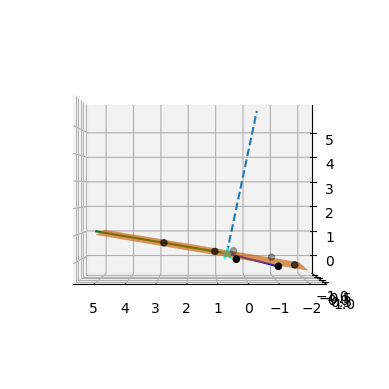

In [22]:
X = np.linspace(-2, 5, 50)
Y = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(X,Y)
n0 = np.cross(lpar, CoM_vector)
d = np.dot(CoMcords, n0)
Z = (d - n0[0]*X - n0[1]*Y) / n0[2]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(partpos[:,0], partpos[:,1], partpos[:,2], color = 'black')
ax.scatter(*CoMcords, marker = '*', s = 72, color = 'cyan')
ax.plot3D(*vect_3d_for_plotting(CoMcords, lpar), color = 'green')
ax.plot3D(*vect_3d_for_plotting(CoMcords, CoM_vector), color = 'blue')
ax.plot3D(*vect_3d_for_plotting(CoMcords, n0), ls = '--')
ax.plot_surface(X,Y,Z) #cmap = matplotlib.cm.Reds)
ax.view_init(roll = 0, elev =0, azim = 90)

## Testing on a pair of PPS monomers with different orientation

In [97]:
pps_rotated =  mb.load("c1ccc(S)cc1", smiles=True)
pps_rotated.rotate(theta = (math.pi/2), around = n1)
pps_rotated.remove(pps_rotated.particles_by_element('H'))
pps.visualize()
#pps_rotated.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [98]:
pps_rotated.save("pps_rotated.gsd", overwrite=True)

In [99]:
file = gsd.hoomd.open("pps_rotated.gsd", "r")
#Finds the real positions of the atoms in the monomer.
frame1 = file[0]
#partpos = particle position
partpos1 = frame1.particles.position
#partmass = particle mass
partmass1 = frame1.particles.mass

In [100]:
#Eventually clean up, because CoMcords and pps_center are the same thing
pps_center1 = get_com(partpos1, partmass1)
lpar1, indicies1 = find_major_axis(partpos1)
print(lpar1)
CoM_vector1 = find_minor_axis(partpos1, pps_center1)
print(CoM_vector1)
vect3d1 = vect_3d_for_plotting(pps_center1, lpar1)
print(vect3d1)

[ 0.05820087  4.587558   -0.11633722]
[-1.637862    1.2239017  -0.34071583]
([-0.011303812, 0.04689706], [0.68188685, 5.2694445], [0.089102246, -0.027234979])


In [103]:
#Need to define our plane and make an angle of rotation
#AB and CoMC are defined in the cell above, they serve as the orignal orientation

#Finds the information from the differently oriented monomer and produces the axis vector
n0 = np.array([0, 0, 1])
n1 = np.cross(lpar, CoM_vector)
n2 = np.cross(lpar1, CoM_vector1)
V_axis1, theta1 = get_axis_angle(n1)
V_axis2, theta2 = get_axis_angle(n2)

#Taking in the axis vector and theta in order to turn the axis angle and theta orientations into zero
quaternion0 = rowan.from_axis_angle(n0, 0)
quaternion1 = rowan.from_axis_angle(V_axis1, theta1)
quaternion2 = rowan.from_axis_angle(V_axis2, theta2)
print(quaternion0, quaternion1, quaternion2)

[1. 0. 0. 0.] [ 0.99562614 -0.01368554 -0.09241908  0.        ] [ 0.99562616 -0.01368551 -0.09241896  0.        ]


In [104]:
def get_axis_angle(n1, n0=np.array([0, 0, 1])):
    """Calculates axis and angle of rotation given two planes normal vectors"""
    V_axis = np.cross(n0, n1)
    theta_numerator = np.dot(n0, n1)
    theta_denominator = np.linalg.norm(n0) * np.linalg.norm(n1)
    theta_rotation = np.arccos(theta_numerator / theta_denominator)
    return V_axis, theta_rotation

In [105]:
s = gsd.hoomd.Snapshot()
s.particles.N = 2
s.particles.types = ['A']
s.particles.typeid = [0,0]
s.particles.position = [[1,1,1], [2,1,2]]
s.particles.orientation = [quaternion1, quaternion2]
s.configuration.box = [8, 8, 8, 0, 0, 0]
s.particles.mass = [2] * 2

In [106]:
with gsd.hoomd.open("test_orientations.gsd", "w") as f:
    f.append(s)

In [ ]:
#State of the state address:
#Orientations coming out identical even though we are rotating plane normal vector in mbuild
#And OVITO is not open anymore apparently :( we need to add all atom and coarse grain visualizations
#into a single HOOMD gsd file first
#And hopefully that will show what is going on
#It's the quaternions that are coming out the same, not OVITO screwing it up, it's probably something to do with
#mbuild and how it stores information or rotations